In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from utilities import plotting
from utilities import stats
from utilities import timestamps
from utilities import import_export
from utilities import polygon_selection
from mpl_toolkits.basemap import Basemap
from itertools import product
import matplotlib.pyplot as plt

In [2]:
# df = pd.read_csv('data/ccu.dat', delimiter='\t', names=['lon', 'lat', 'decimal_year', 'month', 'day', 'mag'
#                                                         , 'depth', 'hour', 'minute', 'second', 'horizontal_error'
#                                                         , 'depth_error', 'mag_err'])
# df['timestamp'] = df.decimal_year.apply(timestamps.convert_decimal_year_to_numpy_datetime64)

df = import_export.import_catalog(location='data/ccu.dat', delimiter='\t', names=['lon', 'lat', 'decimal_year', 'month', 'day', 'mag'
                                                        , 'depth', 'hour', 'minute', 'second', 'horizontal_error'
                                                        , 'depth_error', 'mag_err'])

In [3]:
# df[(df.decimal_year > 2011) & (df.mag >= 6.5) & (df.depth <= 40) & (df.lon.between(142, 143))]

In [4]:
noto_hanto = {'coordinates':(136.686000, 37.220667), 'time':'2007-03-25 00:41:57.909996', 'tz':'UTC', 'magnitude':6.9}
western_tottori = {'coordinates':(133.349, 35.274167), 'time':'2000-10-06 04:30:17.940011', 'tz':'UTC', 'magnitude':6.7}
sugura_bay = {'coordinates':(138.499333, 34.786167), 'time':'2009-08-10 20:07:05.740017', 'tz':'UTC', 'magnitude':6.5}
iwaki = {'coordinates':(140.672667, 36.945667), 'time':'2011-04-11 08:16:12.020008', 'tz':'UTC', 'magnitude':6.6}
iwate_miyage = {'coordinates':(140.880667, 39.029833), 'time':'2008-06-13 23:43:45.359992', 'tz':'UTC', 'magnitude':6.8}
kumamoto = {'coordinates':(130.763, 32.7545), 'time':'2016-04-14 12:26:00', 'tz':'UTC', 'magnitude':7.0}
tohoku = {'coordinates':(142.861000, 38.103500), 'time':'2011-03-11 05:46:18.119983', 'tz':'UTC', 'magnitude':9.0}

def plot_earthquake_on_basemap(eq, m, ax, **kwargs):
    x, y = m(eq['coordinates'][0], eq['coordinates'][1])
    ax.scatter(x, y, s=0.75*np.exp(eq['magnitude']), **kwargs)
    ax.annotate('{year} M{mag}'.format(year=np.datetime64(eq['time']).astype('datetime64[Y]').astype(str)
                                              , mag=str(eq['magnitude']))
                , xy=(x, y), xytext=(x, y+0.5), fontsize=15, color='red', fontweight='bold')

# noto_hanto

In [5]:
eq = noto_hanto# kumamoto

In [6]:
df_regional = polygon_selection.get_node_data(data=df, node=eq['coordinates'], radius=75, m=1)

(<matplotlib.figure.Figure at 0x7f4171c91d30>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4171ca9908>)

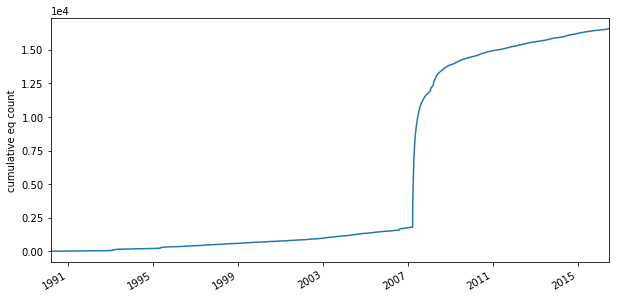

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
plotting.plot_seismicity_rate(dataframe=df_regional[df_regional.mag>=0.5], fig=fig, ax=ax)

In [8]:
df_regional = df_regional.loc[df_regional.index < eq['time']]
df_regional = df_regional[df_regional.depth <=25]
df_regional = df_regional[df_regional.mag >= 0.5]

In [9]:
# fig, ax = plt.subplots(figsize=(10,5))
# plotting.plot_seismicity_rate(dataframe=df_regional.loc[df_regional.index > '2011'], fig=fig, ax=ax)
# # ax.text(s='dfgdfg', x=2003, y=1000)
# # fig.savefig('iwaki_seismicity_cnt.png', dpi=300, bbox_inches='tight')

In [10]:
# df_regional = df_regional.loc[df_regional.index < '2011-03-07']

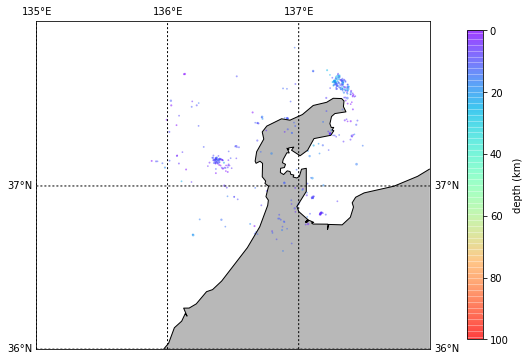

In [11]:
m, fig, ax = plotting.plot_seismicity_map(dataframe=df_regional[df_regional.mag>2])

(0, 25)

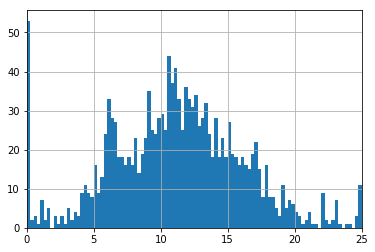

In [12]:
ax = df_regional.depth.hist(bins=100)
ax.set_xlim(0,25)

In [13]:
stats.calc_fmd_stats_with_mc(df_regional[df_regional.distance <=25].mag)

(2.5933600248092912, 0.55253750878276242, 6.508868379921641e-16, 75, 1.2)

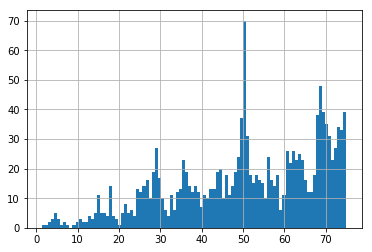

In [14]:
df_regional.distance.hist(bins=100)

In [15]:
radii = np.arange(1, 51, 1)
foreshock_time = eq['time']

timii = pd.date_range(start='01-01-1990 00:00:00', end=foreshock_time, freq='6M', tz='GMT')
parameters = [x for x in product(radii, timii)]
df_regional = df_regional.loc[df_regional.index < foreshock_time]
# df_regional = df_regional[df_regional.mag >= 0.5]
# df_regional = df_regional[df_regional.depth <= 25]
n_iterations = 100

bdf = stats.calculate_b_value_parameter_sweep(dataframe=df_regional
                                              ,location=eq['coordinates']
                                              ,n_iterations=n_iterations
                                              ,parameters=parameters)

/home/max/pymap3/utilities/stats.py:45: RuntimeWarning: invalid value encountered in true_divide
  b_stddev = square_every_value((magnitudes - average).sum()) / (length * (length - 1))


/home/max/anaconda2/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  import sys


(0, 50)

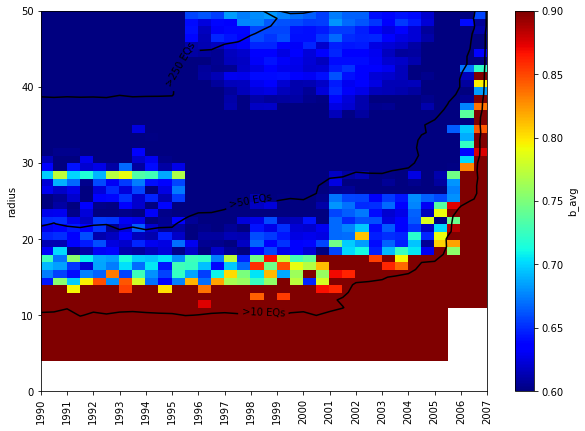

In [16]:
fig, ax = plt.subplots(figsize=(10,7))

fig, ax = plotting.plot_radius_time_sweep(dataframe=bdf, vertical_axis='radius'
                                 , value='b_avg',vmin=0.6, vmax=0.9, cmap='jet', fig=fig, ax=ax)

zi = bdf.pivot(index='start_time', columns='radius', values='n_avg')
xi_label = [np.datetime64(z, 'Y') for z in zi.index]
xi = np.arange(len(xi_label))
yi = zi.columns
xi, yi = np.meshgrid(xi, yi)

zi = np.ma.masked_invalid(zi).transpose()

levels = [10, 50, 250, 1000, 5000]
cs = ax.contour(xi,yi,zi, levels, colors='black')#, locator=ticker.LogLocator())

cs.levels = ['>10 EQs', '>50 EQs','>250 EQs', '>1000 EQs', '>5000 EQs']

ax.clabel(cs, cs.levels, inline=True)
ax.set_ylim(0,50)


# fig.savefig('iwaki_parameter.png', dpi=300, bbox_inches='tight', transparency=True)

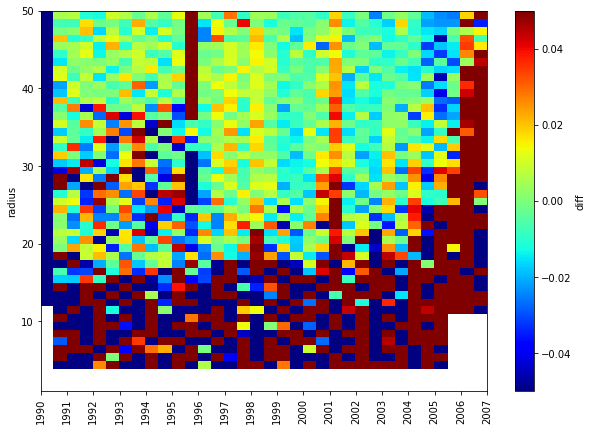

In [17]:
bdf['diff'] = bdf.b_avg.diff()

fig, ax = plt.subplots(figsize=(10,7))

fig, ax = plotting.plot_radius_time_sweep(dataframe=bdf, vertical_axis='radius'
                                 , value='diff',vmin=-0.05, vmax=0.05, cmap='jet', fig=fig, ax=ax)

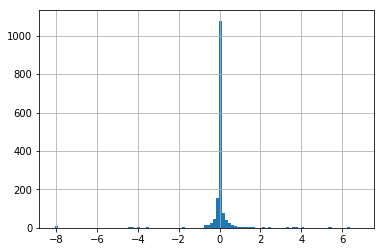

In [18]:
bdf['diff'].hist(bins=100,)

In [19]:
test = pd.DataFrame(columns=['a','b'])
test.apply(lambda x: x['a'] + 1)

,a,b


In [20]:
bdf.describe()

,radius,a_avg,b_avg,bstd_avg,n_avg,mc_avg,a_std,b_std,bstd_std,n_std,mc_std,diff
count,1750.000000,1617.000000,1617.000000,1.608000e+03,1617.000000,1617.000000,1.617000e+03,1.617000e+03,1.608000e+03,1617.000000,1617.000000,1609.000000
mean,25.500000,3.411566,1.114821,5.278177e-16,90.606663,1.178204,1.821086e+00,7.515173e-01,8.738367e-16,22.049397,0.287455,0.006741
std,14.434995,1.943049,1.203781,6.373088e-16,96.583636,0.152506,2.666077e+00,1.090409e+00,1.660500e-15,21.027846,0.131942,1.070465
min,1.000000,1.804496,0.468640,0.000000e+00,1.000000,0.766279,7.280896e-15,3.640448e-15,0.000000e+00,0.000000,0.000000,-8.072336
25%,13.000000,2.451992,0.575939,2.506506e-16,12.806122,1.097000,1.083914e-01,6.496218e-02,2.354813e-16,5.120607,0.184161,-0.017474
50%,25.500000,2.884057,0.632866,3.711320e-16,50.260000,1.157000,2.842554e-01,1.431378e-01,3.827619e-16,13.640863,0.254239,0.000656
75%,38.000000,3.188401,0.981514,5.343204e-16,139.530000,1.238000,3.252143e+00,1.179352e+00,5.783547e-16,34.150107,0.359011,0.032333
max,50.000000,17.371779,8.685890,7.085424e-15,387.150000,1.774000,1.022231e+01,3.936678e+00,1.645738e-14,90.466032,0.668238,6.818888


In [21]:
df_calc = df_regional.copy()

rows = []

for r, t in parameters:
    df_c = polygon_selection.get_node_data(node=eq['coordinates'], data=df_calc, radius=r, m=1)
    df_c = df_c.loc[df_c.index >= t]
    
    a, b, bstd, n, mc = stats.calc_fmd_stats_with_mc(df_c.mag)
    row = np.array((r,) + (t,) + (a, b, bstd, n, mc))
    rows.append(row)
    

/home/max/pymap3/utilities/stats.py:45: RuntimeWarning: invalid value encountered in true_divide
  b_stddev = square_every_value((magnitudes - average).sum()) / (length * (length - 1))


In [22]:
rows[0]

array([1, Timestamp('1990-01-31 00:00:00+0000', tz='GMT'), nan, nan, nan,
       nan, nan], dtype=object)

In [23]:
true_bdf = pd.DataFrame(rows, columns=['radius', 'start_time', 'a', 'b', 'bstd', 'n', 'mc'])
    
    
    

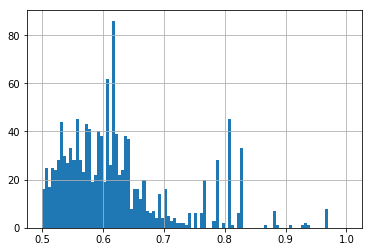

In [24]:
true_bdf.b.hist(bins=100,range=(0.5, 1))

In [25]:
# df_calc = df_regional.copy()

In [26]:
# polygon_selection.get_node_data(node=eq['coordinates'], data=df_calc, radius=5, m=1)

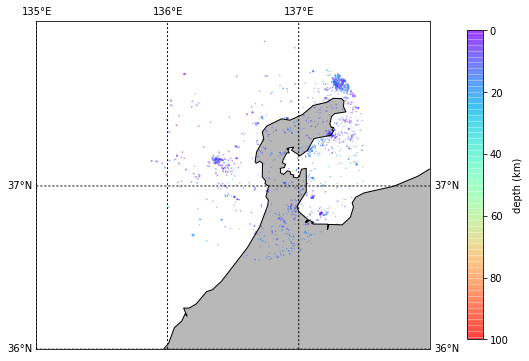

In [27]:
m, fig, ax = plotting.plot_seismicity_map(df_calc)


In [28]:
eq

{'coordinates': (136.686, 37.220667),
 'magnitude': 6.9,
 'time': '2007-03-25 00:41:57.909996',
 'tz': 'UTC'}

/home/max/anaconda2/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  if __name__ == '__main__':


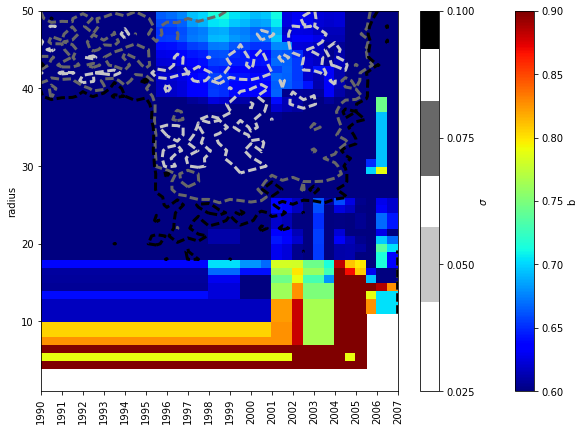

In [29]:
import scipy.ndimage

fig, ax = plt.subplots(figsize=(10,7))

fig, ax = plotting.plot_radius_time_sweep(dataframe=true_bdf, vertical_axis='radius'
                                 , value='b',vmin=0.6, vmax=0.9, cmap='jet', fig=fig, ax=ax)

zi = bdf.pivot(index='start_time', columns='radius', values='b_std')
xi_label = [np.datetime64(z, 'Y') for z in zi.index]
xi = np.arange(len(xi_label))
yi = zi.columns
xi, yi = np.meshgrid(xi, yi)

zi = np.ma.masked_invalid(zi).transpose()

# levels = [10, 50, 250, 1000, 5000]
levels = [0.025, 0.05, 0.075, 0.1]
cs = ax.contour(xi,yi,zi, levels, cmap='Greys', linewidths=3, linestyles='--')#, locator=ticker.LogLocator())
# cs = ax.contourf(xi,yi,zi, levels, cmap='Greys', linewidths=3, linestyles='--', alpha=0.0)#, locator=ticker.LogLocator())
# cs = ax.contour(xi,yi,zi, colors='black')#, locator=ticker.LogLocator())

# cs.levels = ['$\pm 0.2 \sigma$', '>50 EQs','>250 EQs', '>1000 EQs', '>5000 EQs']

# ax.clabel(cs, cs.levels, inline=True)
# ax.set_ylim(0,50)

cb = fig.colorbar(cs, label='$\sigma$')
for line in cb.lines:
    line.set_linewidth(75)
fig.savefig('b_std_noto_hanto_parameter.png', dpi=300, bbox_inches='tight', transparency=True)

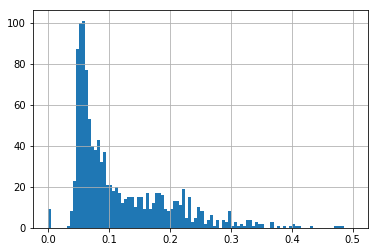

In [30]:
bdf.b_std.hist(bins=100, range=(0,0.5))

In [32]:
bdf.to_csv('b_noto_hanto_4_13_2017.csv', index=False)

In [34]:
true_bdf.to_csv('b_true_noto_hanto_4_13_2017.csv', index=False)